# Customer Insights

-data imported
--client data filtered
---client data prepared
----appointment data prepared
-----client data joined to appointment data
------data prepared
-------data normalized
--------data split into training and test samples
---------training data resampled
 
training and calibrating Random Forest (approximately: 1.5 minutes)
...
random forests trained and calibrated
 
No-Show AUC-ROC: 0.715280777537797
Cancellation AUC-ROC: 0.6511731466126159
 
running cross-validation test on No-Show Model (approximately: 1 minute)
...
 
Cross-validated No-Show AUC-ROC scores: [np.float64(0.9879503285560972), np.float64(0.9981878892404683)]
Mean No-Show AUC-ROC: 0.9898314351855528
 
running cross-validation test on Cancellation Model (approximately: 1 minute)
...
 
Cross-validated Cancellation AUC-ROC scores: [np.float64(0.9879503285560972), np.float64(0.9981878892404683)]
Mean Cancellation AUC-ROC: 0.9898314351855528
 
Chance of Cancelled: 17.34%


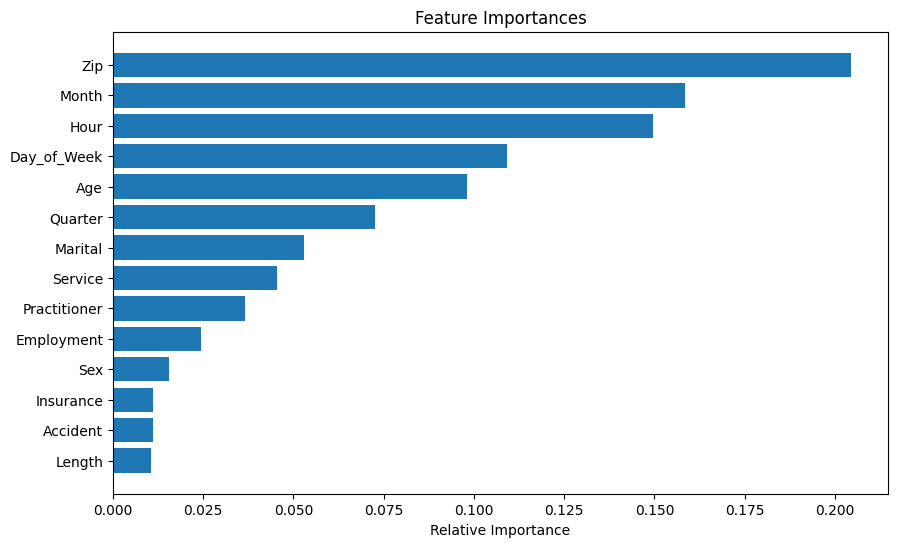

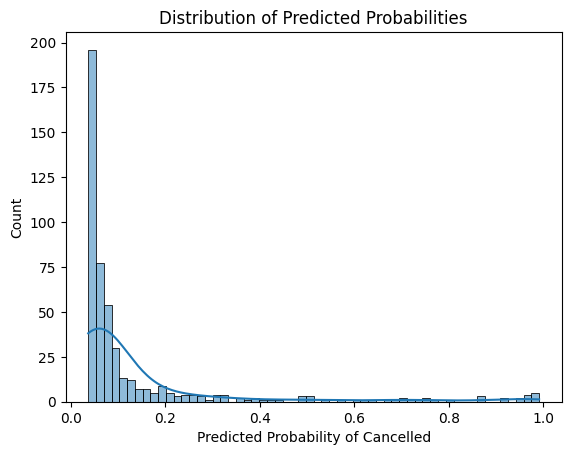

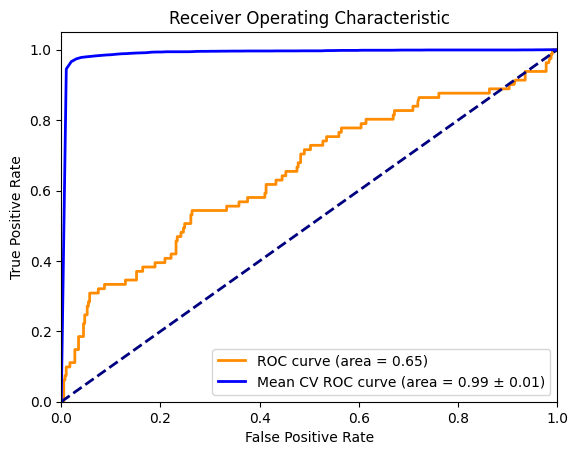

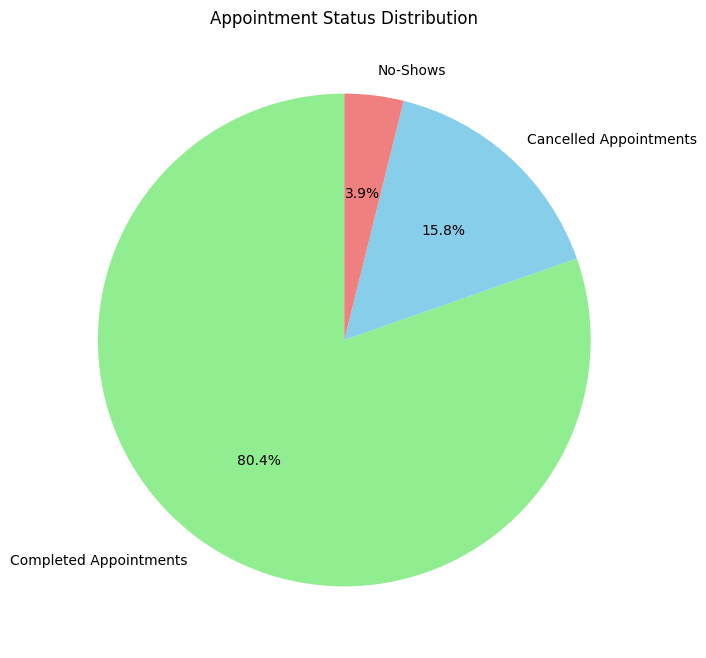

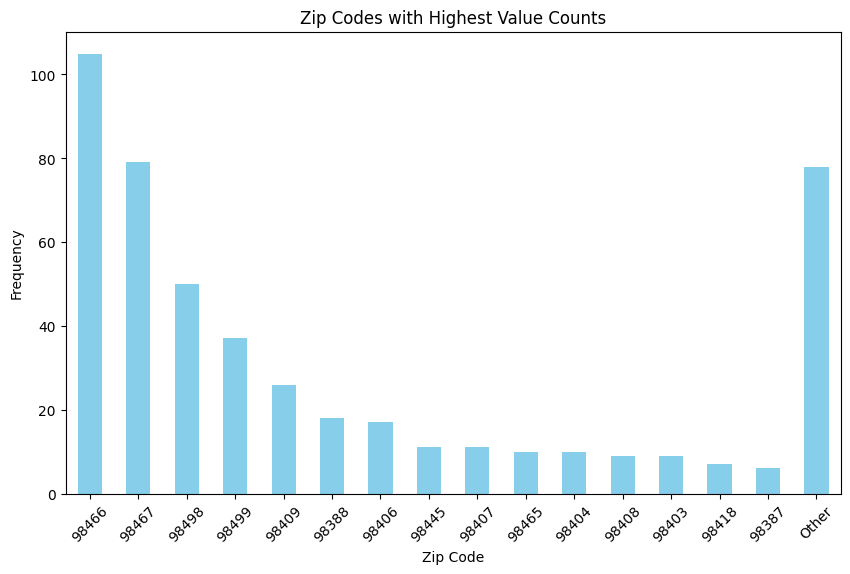

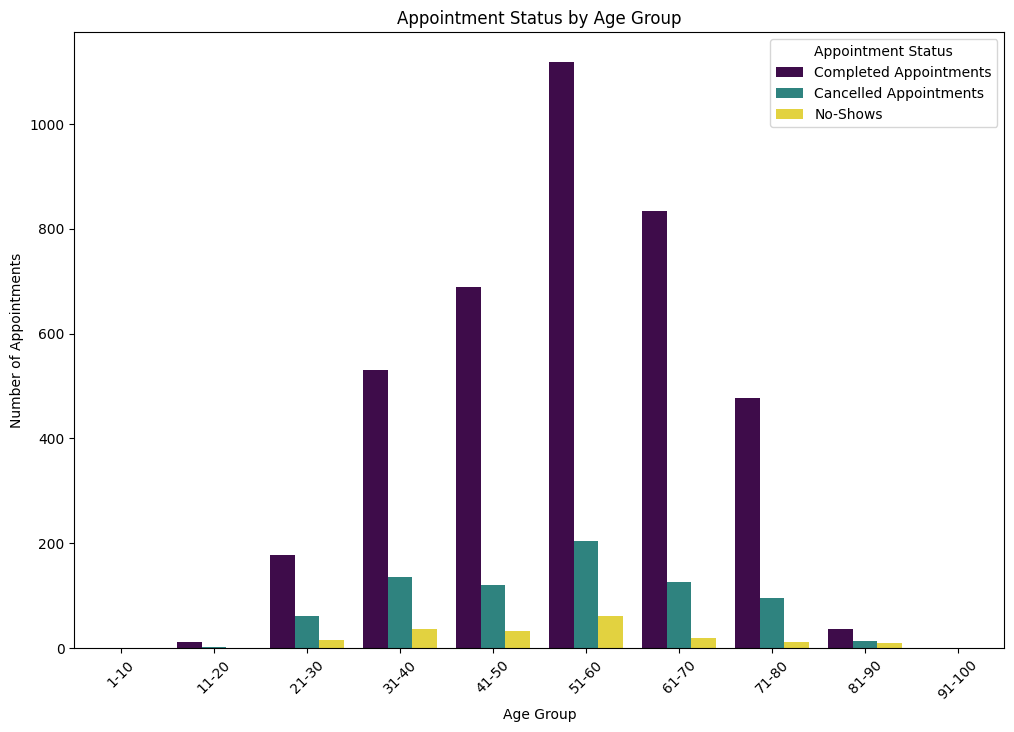

In [1]:
run CustomerInsights.py

-data imported
--client data filtered
---client data prepared
----appointment data prepared
-----client data joined to appointment data
------data prepared
-------data normalized
--------data split into training and test samples
---------training data resampled
 
training and calibrating Random Forest (approximately: 1.5 minutes)
...
random forests trained and calibrated
 
No-Show AUC-ROC: 0.722732181425486
Cancellation AUC-ROC: 0.6616454763220933
 
running cross-validation test on No-Show Model (approximately: 1 minute)
...
 
Cross-validated No-Show AUC-ROC scores: [0.9881204047402627, 0.998059862488661]
Mean No-Show AUC-ROC: 0.9898798388622152
 
running cross-validation test on Cancellation Model (approximately: 1 minute)
...
 
Cross-validated Cancellation AUC-ROC scores: [0.9881204047402627, 0.998059862488661]
Mean Cancellation AUC-ROC: 0.9898798388622152
 
Chance of Cancelled: 14.49%


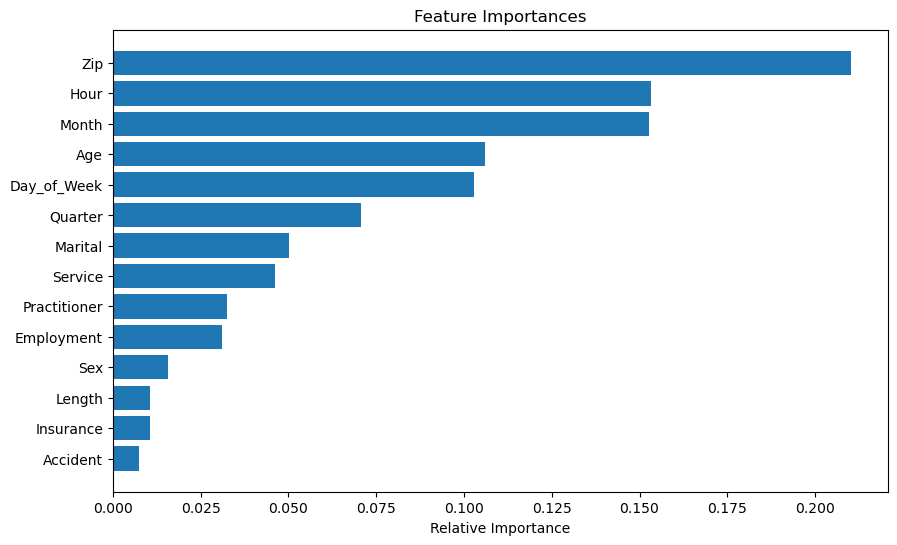

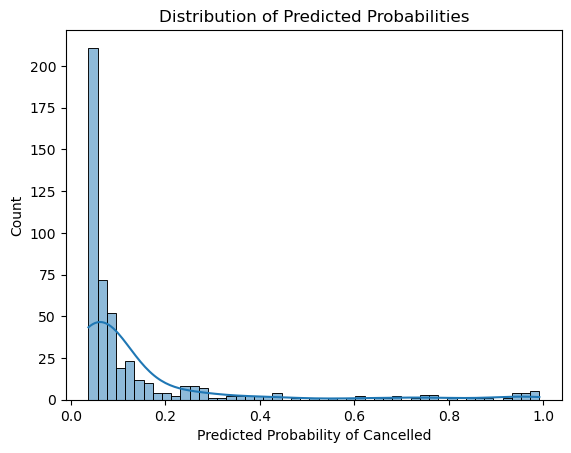

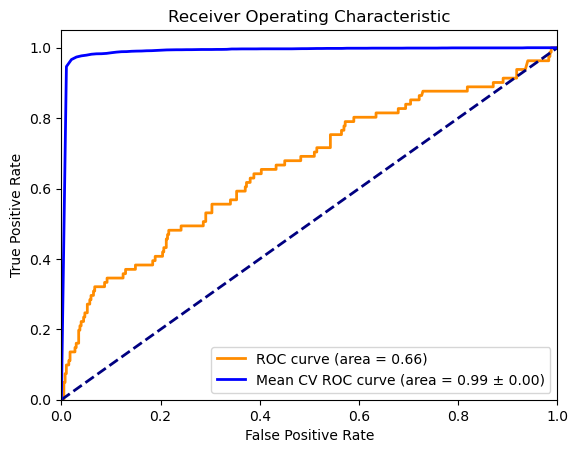

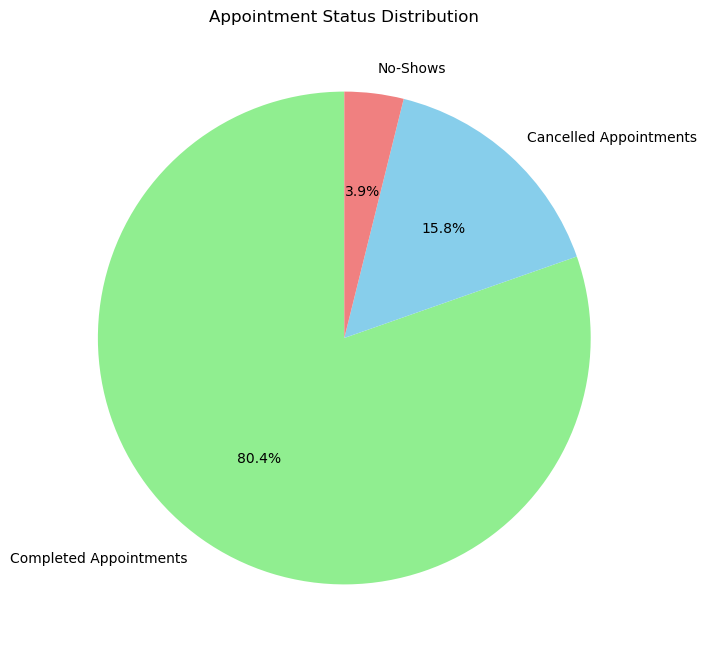

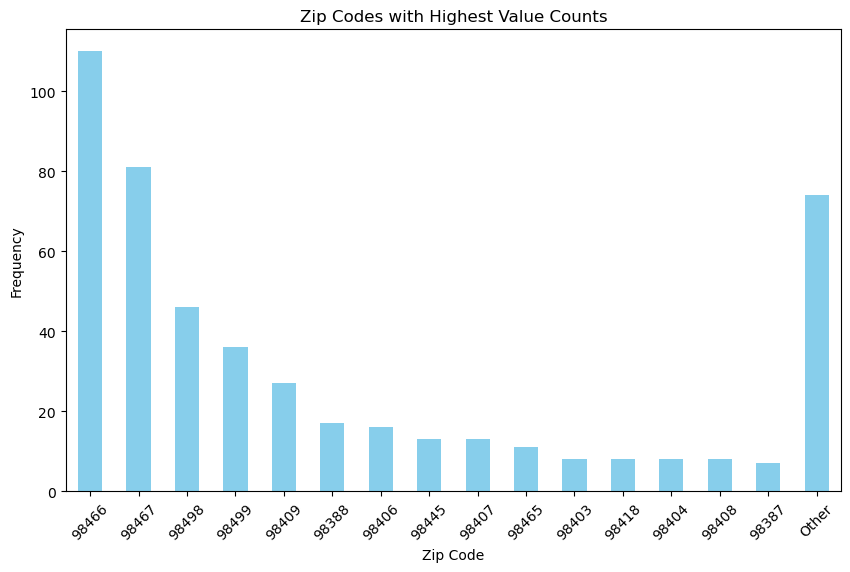

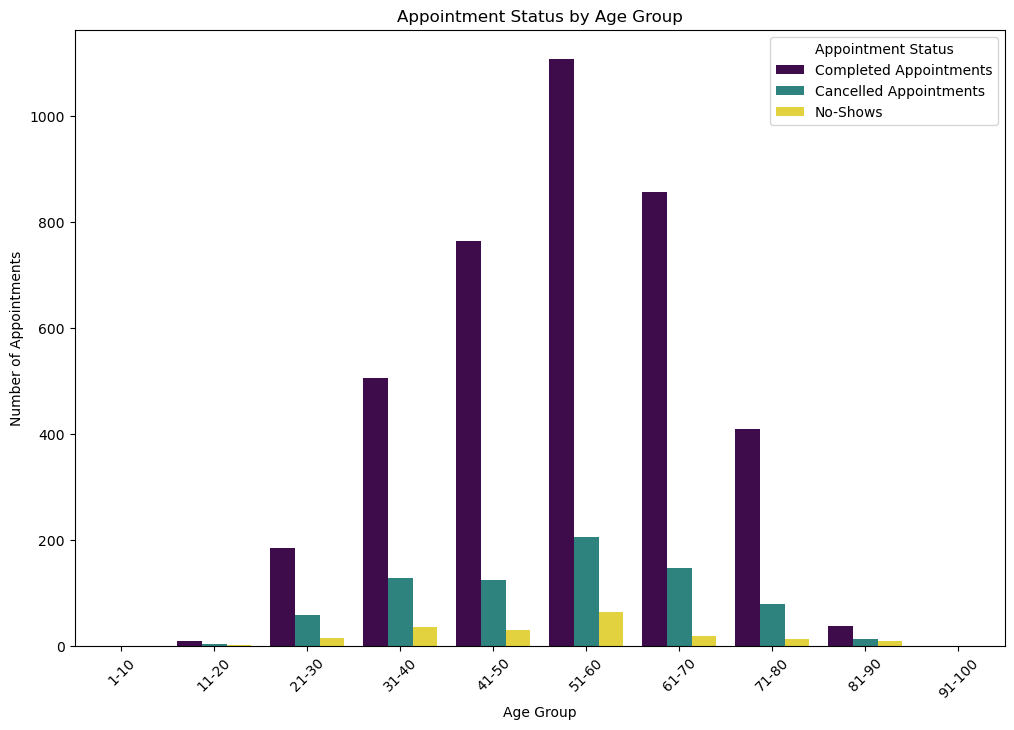

In [49]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# CustomerInsights.py

"""
Description:
Author: Kyle Heckard
Date Created: October 21, 2024
Version 1.0
Python Version: 3.12.3
Dependencies: pandas, matplotlib, scipy, seaborn, scikit-learn, numpy
"""

## Imports

In [5]:
# %% Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import sklearn as skl
import numpy as np
from datetime import datetime
import warnings

In [6]:
# %% Load Raw Data (csv)

clientData_unfiltered = pd.read_csv("Clients.csv")
appointmentData = pd.read_csv("Appointments.csv")

In [7]:
# %% General Declarations

col_index = None #Holds column index
ds = None        #Holds currently worked on data slice

## Data Preparation

### Prepare Client Data

In [10]:
# %% Filter out clients with no appointment data and reset index

clientData = clientData_unfiltered[clientData_unfiltered['Account_Number'].isin(appointmentData['Account_Number'])]
clientData = clientData.reset_index(drop=True)

In [11]:
# %% ignore SettingWithCopyWarning

warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [12]:
# %% Add column i_sex that uses integers to represent client sex

# If sex is M then 1, if F then 2, else nan
ds = clientData['Sex']
clientData.loc[:, 'i_Sex'] = np.where(ds == 'M', 1, #Male
                             np.where(ds == 'F', 2, #Female
                             np.where(ds == 'O', 3, #Other
                             np.nan)))              #No Entry

# Get index of Sex and move i_Sex behind it
col_index = clientData.columns.get_loc('Sex')
clientData.insert(col_index + 1, 'i_Sex', clientData.pop('i_Sex'))

In [13]:
# %% Add column age to clientData and calculate age from Birth_Year

# Get current year
current_year = datetime.now().year

# Where Birth_Year is 1900, age is nan, else age = currentYear - BirthYear
clientData.loc[:, 'i_Age'] = np.where(clientData['Birth_Year'] == 1900,
                             np.nan,
                             current_year - clientData['Birth_Year'])

# Get index of BirthYear and move 'Age' behind it
col_index = clientData.columns.get_loc('Birth_Year')
clientData.insert(col_index + 1, 'i_Age', clientData.pop('i_Age'))

In [14]:
# %% Marital Status

ds = clientData['Marital_Status']
clientData.loc[:, 'i_MaritalStatus'] = np.where(ds == 'M', 1, #Married
                                       np.where(ds == 'C', 2, #Common-Law
                                       np.where(ds == 'D', 3, #Divorced
                                       np.where(ds == 'W', 4, #Widowed
                                       np.where(ds == 'S', 5, #Single
                                       np.where(ds == 'O', 6, #Other
                                       np.nan))))))           #No Entry

# Get index of Marital_Status and move 'i_MaritalStatus' behind it
col_index = clientData.columns.get_loc('Marital_Status')
clientData.insert(col_index + 1, 'i_MaritalStatus', clientData.pop('i_MaritalStatus'))

In [15]:
# %% Employment Status

ds = clientData['Employment_Status']
clientData.loc[:, 'i_Employment'] = np.where(ds == 'E', 1,  #Employed
                                    np.where(ds == 'S', 2,  #Student
                                    np.where(ds == 'R', 3,  #Retired
                                    np.where(ds == 'UE', 4, #Unemployed
                                    np.where(ds == 'O', 5,  #Other
                                    np.nan)))))             #No Entry

col_index = clientData.columns.get_loc('Employment_Status')
clientData.insert(col_index + 1, 'i_Employment', clientData.pop('i_Employment'))

In [16]:
# %% Is condition due to an accident

ds = clientData['Is_condition_due_to_an_accident']
clientData.loc[:, 'Accident'] = np.where(ds == "[u'No']", 0,  #No
                                np.where(ds == 'No', 0,       #No
                                np.where(ds == "[u'Yes']", 1, #Yes
                                np.where(ds == 'Yes', 1,      #Yes
                                np.nan))))                    #No Entry

col_index = clientData.columns.get_loc('Is_condition_due_to_an_accident')
clientData.insert(col_index + 1, 'Accident', clientData.pop('Accident'))

In [17]:
# %% Remove unused columns

del clientData['City']
del clientData['State_Province']
del clientData['Country']
del clientData['Sex']
del clientData['Birth_Year']
del clientData['Marital_Status']
del clientData['Employment_Status']
del clientData['Is_condition_due_to_an_accident']
del clientData['Reminder_Preference']
del clientData['Subscribed_Reminders']
del clientData['Subscribed_Recalls']
del clientData['Subscribed_Email_Campaigns']
del clientData['Subscribed_Birthday_Campaigns']
del clientData['Subscribed_Availability_Campaigns']
del clientData['Subscribe_Referral_Campaigns']
del clientData['Subscribe_Client_Satisfaction']

In [18]:
# %% Randomly assign values to NaNs based on Frequency of values in same column

# Fills NaNs based on how often other values in a column occur to maintain distribution
def fill_na_with_frequencies(series, value_counts):
    na_indices = series[series.isna()].index
    fill_values = np.random.choice(value_counts.index, size=len(na_indices), p=value_counts.values)
    series.loc[na_indices] = fill_values
    return series

# Zip Codes
ds = clientData['Zip_PostalCode']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Sex
ds = clientData['i_Sex']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Age
ds = clientData['i_Age']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Marital Status
ds = clientData['i_MaritalStatus']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Employment Status
ds = clientData['i_Employment']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Is condition caused by accident
ds = clientData['Accident']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

## Prepare Appointment Data

In [20]:
# %% Set appointmentData[Date] to Datetime format

appointmentData['Date'] = pd.to_datetime(appointmentData['Date'], format='%b %d, %Y @ %I:%M%p')

In [21]:
# %% Dates
appointmentData['Quarter'] = appointmentData['Date'].dt.quarter
appointmentData['Month'] = appointmentData['Date'].dt.month
appointmentData['Str_Day_of_Week'] = appointmentData['Date'].dt.day_name()
appointmentData['Hour'] = appointmentData['Date'].dt.hour

ds = appointmentData['Str_Day_of_Week']
appointmentData.loc[:, 'Day_of_Week'] = np.where(ds == 'Sunday', 0,
                                        np.where(ds == 'Monday', 1,
                                        np.where(ds == 'Tuesday', 2,
                                        np.where(ds == 'Wednesday', 3,
                                        np.where(ds == 'Thursday', 4,
                                        np.where(ds == 'Friday', 5,
                                        np.where(ds == 'Saturday', 6,
                                        np.nan)))))))

col_index = appointmentData.columns.get_loc('Str_Day_of_Week')
appointmentData.insert(col_index + 1, 'Day_of_Week', appointmentData.pop('Day_of_Week'))

In [22]:
# %% List Services

services = ['30 minute 30 Minute Add-On',
            '60 minute Deep Tissue Massage',
            '60 minute Relaxation Massage',
            '60 minute Pregnancy Massage',
            '60 minute Insurance Massage',
            '60 minute Pregnancy Insurance Massage',
            '60 minute L&amp;I Massage',
            '60 minute Motor Vehicle Accident (MVA) Massage',
            '90 minute Deep Tissue Massage',
            '90 minute Relaxation Massage',
            '90 minute Insurance Massage',
            '90 minute Pregnancy Insurance Massage'
            ]

In [23]:
# %% Services

def find_index(value, array):
    try:
        return array.index(value)
    except ValueError:
        return -1


ds = appointmentData['Service']
appointmentData['int_Service'] = ds.apply(lambda x: find_index(x, services))

In [24]:
# %% Length

def find_length(value, array):
    try:
        if array.index(value) == 0:
            return 30
        if (array.index(value) >= 1) and (array.index(value) <= 7):
            return 60
        if (array.index(value) >= 8) and (array.index(value) <= 11):
            return 90
    except ValueError:
        np.nan
        
ds = appointmentData['Service']
appointmentData['Length'] = ds.apply(lambda x: find_length(x, services))

In [25]:
# %% Insurance

def find_insurance(value, array):
    try:
        if ((array.index(value) >= 0) and (array.index(value) <= 3)) or ((array.index(value) >= 8) and (array.index(value) <= 9)):
            return 0
        if ((array.index(value) >= 4) and (array.index(value) <= 7)) or ((array.index(value) >= 10) and (array.index(value) <= 11)):
            return 1
    except ValueError:
        np.nan

ds = appointmentData['Service']
appointmentData['Insurance'] = ds.apply(lambda x: find_insurance(x, services))

In [26]:
# %% Status

ds = appointmentData['Status']
appointmentData.loc[:, 'int_Status'] = np.where(ds == 'PAID', 1,
                                       np.where(ds == 'DUE', 1,
                                       np.where(ds == 'CANCELLED', 2,
                                       np.where(ds == 'NO SHOW', 3,
                                       np.nan))))

In [27]:
# %% Remove unused columns

del appointmentData['Date']
del appointmentData['Str_Day_of_Week']
del appointmentData['Service']
del appointmentData['Status']